## Tarea Semanal Nro 7 | Filtrado digital lineal de ECG

#### **Introducción y fundamentos teóricos**
##### *Propuesta*

Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:


- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

#### *Filtros FIR e IIR*

Los filtros fir son filtros no recursivos, esto quiere decir que no dependen de sus salidas pasadas. Son filtros estables, y de respuesta finita. Por otro lado, los filtros iir son filtros recursivos, dependen de salidas anteriores y pueden ser inestables. El gran beneficio de los filtros fir es que pueden tener fase lineal o demora constante (algo sencillo de corregir) mientras que los iir presentan distorciones de fase.

| Característica                      | Filtros FIR                                 | Filtros IIR                                 |
|------------------------------------|---------------------------------------------|---------------------------------------------|
| **Estabilidad**                    | Siempre estables                            | Pueden ser inestables si no se diseñan bien |
| **Fase**                           | Fase lineal (ideal para preservar forma)    | Fase no lineal (puede distorsionar formas)  |
| **Complejidad computacional**      | Más altos órdenes → mayor costo             | Más eficientes (menor orden necesario)      |
| **Retardo de grupo**               | Constante (ideal para señales biológicas)   | Variable                                     |
| **Uso típico**                     | Cuando se requiere alta fidelidad y fase lineal | Cuando se requiere eficiencia computacional |




In [53]:
from pytc2.sistemas_lineales import plot_plantilla
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import firls

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)



In [54]:


#Cargar la señal ECG
fs = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()
qrs_det = mat_struct['qrs_detections'].flatten()

# Normalización tipo z-score: (x - media) / std
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Aplicar normalización
ecg = normalize(ecg)
hb1 = normalize(hb1)
hb2 = normalize(hb2)
qrs = normalize(qrs)

# Crear un vector de tiempo para la señal ECG completa
t_ecg = np.arange(len(ecg)) / fs

# Crear vectores de tiempo para los patrones (usualmente de menor duración)
t_hb1 = np.arange(len(hb1)) / fs
t_hb2 = np.arange(len(hb2)) / fs
t_qrs = np.arange(len(qrs)) / fs




#### Armo una plantilla de diseño con los siguientes requerimientos

f_stop1 = 0.1 Hz (Contaminación de la línea de base)

f_pass1 = 1 Hz (Mínima frecuencia de la onda T)

f_pass2 = 35 Hz (Ancho de banda calculado en la Ts 5)

f_stop2 = 50 Hz (Ruido de la red eléctrica en Argentina)

OBSERVACIONES: Tenemos una primer banda de transición muy exigente! 

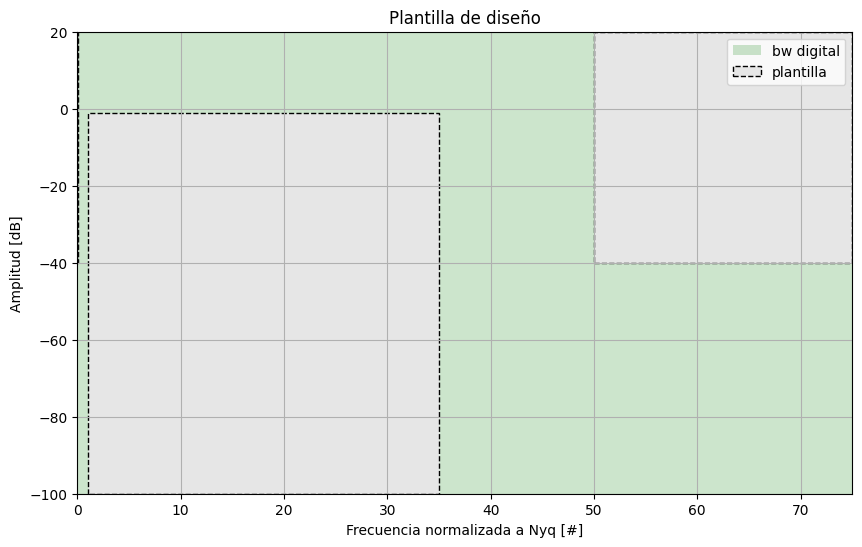

In [55]:

#########################################
########## PLANTILLA DE DISEÑO ##########
#########################################

# Configuración de la plantilla de diseño del filtro
fpass = np.array([1,35])
ripple = 1
fstop = np.array([0.1,50.0])
attenuation = 40

plt.figure(figsize=(10, 6))
plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.xlim(0, 75)
plt.ylim(-100,20)
plt.grid(which='both', axis='both')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)



# Grilla logarítmica y lineal en Hz
w_log = np.logspace(np.log10(0.1), np.log10(20), 600)   # logarítmica de 0.1 a 20 Hz
w_lin = np.linspace(20, fs/2, 600, endpoint=True)       # lineal de 20 Hz a fs/2
w_rad = np.unique(np.concatenate((w_log, w_lin)))       # une y elimina duplicados
w_rad = np.unique(w_rad)  # elimina duplicados 



#### Armo los filtros tipo IIR y verifico que cumplen con la plantilla sin problemas

¿Porque?

Requieren menor orden

Son mas eficientes (a costa de hacer un desastre con la fase)

**Observaciones:**

El filtro butter presenta máxima planicidad en la banda de atenuación y una curva monótona decreciente en la de trancisión.

El filtro cheby de tipo 1 presenta ondulaciones en la banda de atenuación (la cantidad de toques corresponde con el orden) y una curva con mayor pendiente a la salida.






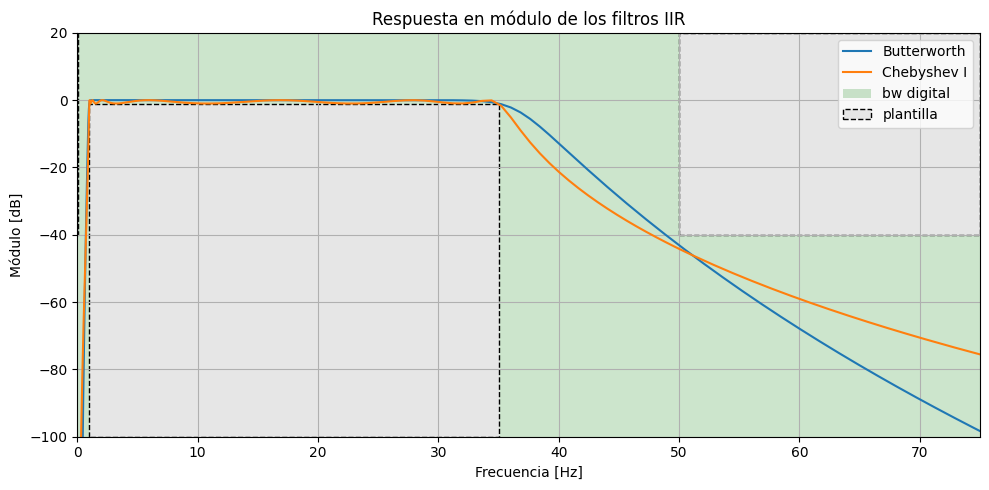

In [56]:

###########################################
############### FILTROS IIR ###############
###########################################

############# BUTTER ###############
sos_filter_vent = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype='butter', output='sos',fs=fs)
w_b, hh_b = sig.sosfreqz(sos_filter_vent, worN=w_rad, fs=fs)

############# CHEBVY 1 ###############
sos_filter_ch = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype='cheby1', output='sos',fs=fs)
w_c, hh_c = sig.sosfreqz(sos_filter_ch, worN=w_rad, fs=fs)

# Graficar la respuesta en módulo (dB)
plt.figure(figsize=(10, 5))
plt.plot(w_b, 20 * np.log10(np.abs(hh_b) + 1e-15), label='Butterworth')
plt.plot(w_c, 20 * np.log10(np.abs(hh_c) + 1e-15), label='Chebyshev I')
plt.title('Respuesta en módulo de los filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 75)
plt.ylim(-100,20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)



#### Armo los filtros FIR en cascada, con ordenes enormes y observo que aún así tienen problemas para cumplir con las especificaciones de la plantilla

Los filtros fir necesitan ordenes enormes para funcionar. Partí el filtro en dos para poder asignarles valores de orden diferentes a las dos transiciones. La primera que es más exigente le puse un orden de 1501 y a la segunda uno menor 501. Recuerdo que los odenes deben ser impares porque de lo contrario se coloca un 0 en nyquist y arruino el filtro. 

Una posible solución al no cumplimiento de la plantilla sería subir el valor del ripple, pero corremos el riesgo de atenuar frecuencias de valor

En el gráfico observo que el método de ventanas cumple mejor que el de cuadrados mínimos. esto puede deberse a que el método de cuadrados mínimmos minimiza el error (la diferencia entre mi respuesta ideal y la que obtengo) de tipo cuadrático global. Puede ser que en ciertas regiones de mi plantilla el error sea mínimo pero en otras muy grande. El filtro no lo distingue

Una opción más sofisticada sería usar el metodo de couer que me asegura el equirriple.


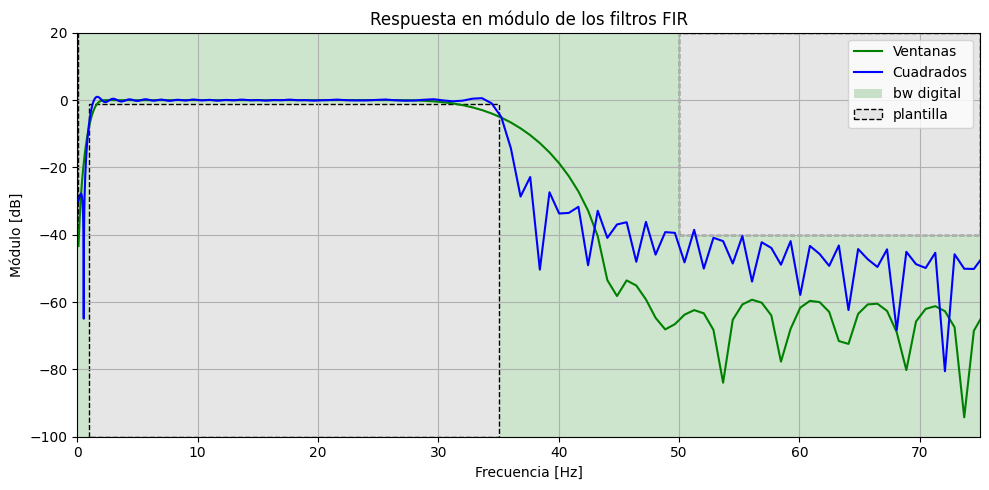

In [57]:

###########################################
############### FILTROS FIR ###############
###########################################


######### METODO VENTANAS #########
# --- Filtro pasaaltos FIR ---
freq_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
gain_hp = [0, 0, 1, 1]
freq_hp = np.array(freq_hp)

numtaps = 1501  # Orden 
b_hp = sig.firwin2(numtaps, freq_hp, gain_hp, fs=fs)

# --- Filtro pasabajos FIR ---
freq_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
gain_lp = [1, 1, 0, 0]
freq_lp = np.array(freq_lp)

numtaps = 201  # Orden 
b_lp = sig.firwin2(numtaps, freq_lp, gain_lp, fs=fs)

# --- Convolucionamos ambos filtros para obtener el pasabanda ---
b_vent = np.convolve(b_hp, b_lp)

# --- Respuesta en frecuencia del filtro FIR pasabanda ---
w_fir, h_fir = sig.freqz(b_vent, worN=w_rad, fs=fs)

####### METODO CUADRADOS MINIMOS #########

# --- Filtro pasaaltos FIR (firls) ---
numtaps = 1501  # Orden 
bands_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
desired_hp = [0, 0, 1, 1]
bands_hp = np.array(bands_hp)
bands_hp_norm = bands_hp / (fs/2)
b_firls_hp = firls(numtaps, bands_hp_norm, desired_hp)

# --- Filtro pasabajos FIR (firls) ---
numtaps = 501  # Orden 
bands_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
desired_lp = [1, 1, 0, 0]
bands_lp = np.array(bands_lp)
bands_lp_norm = bands_lp / (fs/2)
b_firls_lp = firls(numtaps, bands_lp_norm, desired_lp)

# --- Convolucionamos ambos filtros para obtener el pasabanda ---
b_firls = np.convolve(b_firls_hp, b_firls_lp)

# --- Respuesta en frecuencia del filtro FIR pasabanda (firls) ---
w_firls, h_firls = sig.freqz(b_firls, worN=w_rad, fs=fs)


# --- Graficar junto a los FIR ---
plt.figure(figsize=(10, 5))
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-15), label='Ventanas', color='green')
plt.plot(w_firls, 20 * np.log10(np.abs(h_firls) + 1e-15), label='Cuadrados', color='blue')
plt.title('Respuesta en módulo de los filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 75)
plt.ylim(-100, 20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.show()



#### Aplico los filtros con filtfilt para miticar las demoras y distorsión de fase


Tecnicamente, si se que voy a plicar los filtros bidireccionalmente, debería armar una plantilla con los valores de atenuación divididos a la mitad, pero el profesor dijo que en este caso no va a cambiar mucho.

Para los filtros fir, sabiendo que los calculados a partir de los metodos tienen fase lineal, podría calcular la demora y restarla directamente, pero me resultó más sencillo aplicarles filt filt directo.

In [58]:

#########################################
######### APLICANDO LOS FILTROS #########
#########################################


# Aplicar el filtro Butterworth (sin desfase)
ecg_butter = sig.sosfiltfilt(sos_filter_vent, ecg)
# Aplicar el filtro Chebyshev I (sin desfase)
ecg_cheby = sig.sosfiltfilt(sos_filter_ch, ecg)
# Aplicar el filtro FIR por Ventanas (sin desfase)
ecg_vent = sig.filtfilt(b_vent, 1.0, ecg)
# Aplicar el filtro FIR por Cuadrados Mínimos (sin desfase)
ecg_cuad = sig.filtfilt(b_firls, 1.0, ecg)



#### Grafico las regiones de interes y observo el filtrado en cada caso. 


Observo que las ondas lentas se corrigieron bastante bien, veo la linea de base corregida. Veo también que la morfología del complejo qrs esta conservada en su mayoría. Lo que no me gusta tanto son algunas altas frecuencias en el segmento PQ. Cuadrados minimos no corrigió tan bien las altas frecuencias. Particularmente el de ventanas me sorprendió. Es un filtro tipo fir que sin recursividad logró suavisar la señal para ondas rapidas y corregir la linea de base.

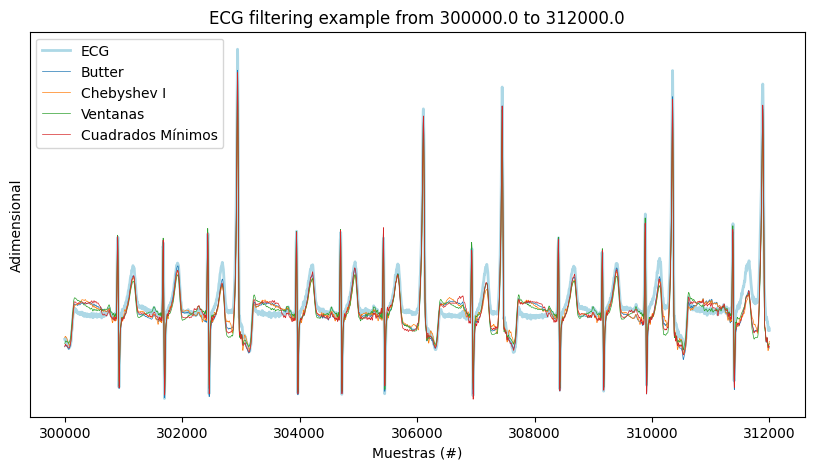

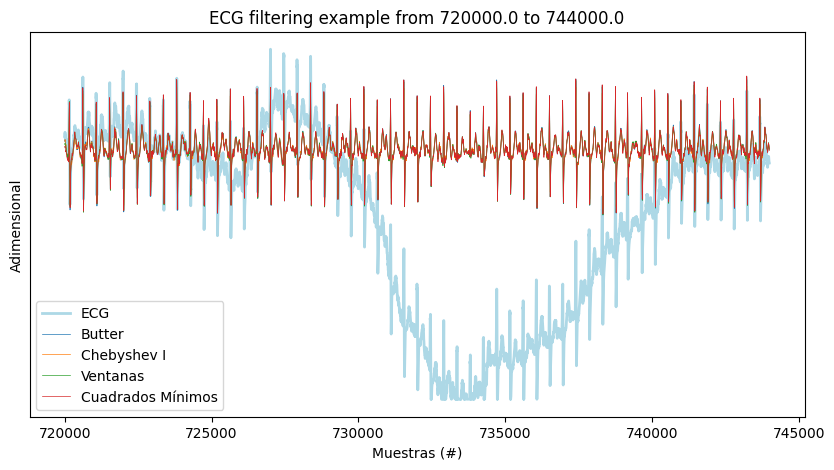

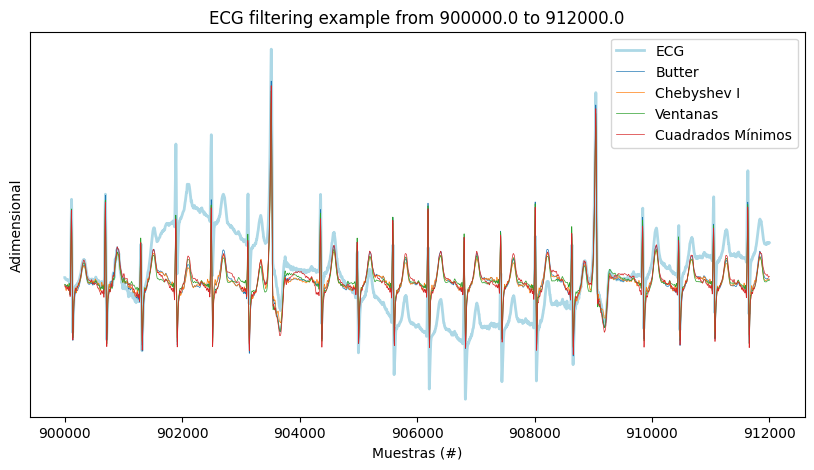

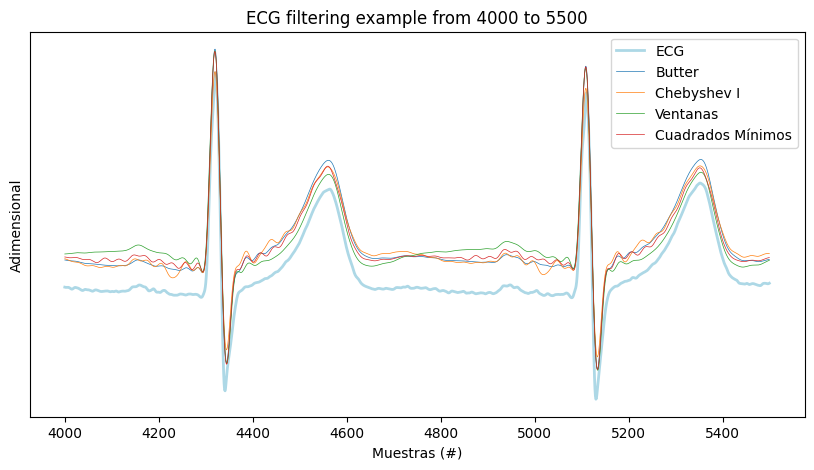

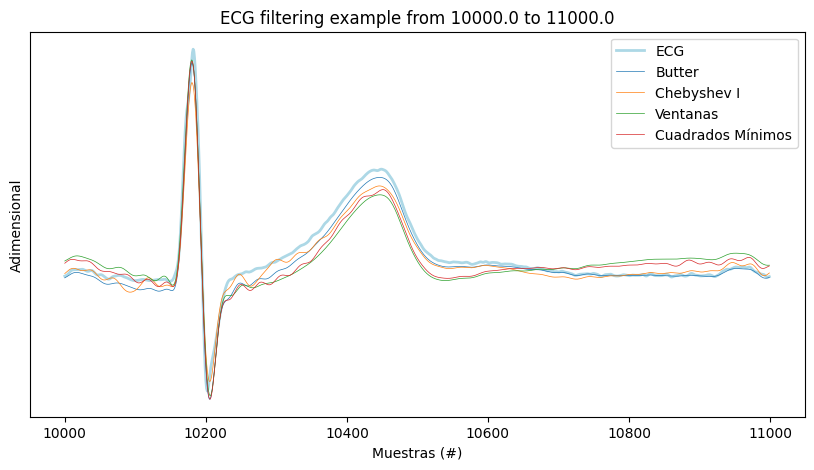

In [59]:

########### GRAFICOS TEMPORALES ###########

cant_muestras = ecg.shape[0]
fig_sz_x = 10
fig_sz_y = 5
fig_dpi = 100
demora = 0

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2,color='lightblue')
    plt.plot(zoom_region, ecg_butter[zoom_region + demora], label='Butter',linewidth=0.5)
    plt.plot(zoom_region, ecg_cheby[zoom_region + demora], label='Chebyshev I',linewidth=0.5)
    plt.plot(zoom_region, ecg_vent[zoom_region + demora], label='Ventanas',linewidth=0.5)
    plt.plot(zoom_region, ecg_cuad[zoom_region + demora], label='Cuadrados Mínimos',linewidth=0.5)

    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

    ###### ESPECTROGRAMAS ######

    # Calcular el periodograma de Welch para cada señal
nperseg = 2048


#### Gráfico espectral, chequeo que mitigue las frecuencias correspondientes y comparo las atenuaciones de cada filtro

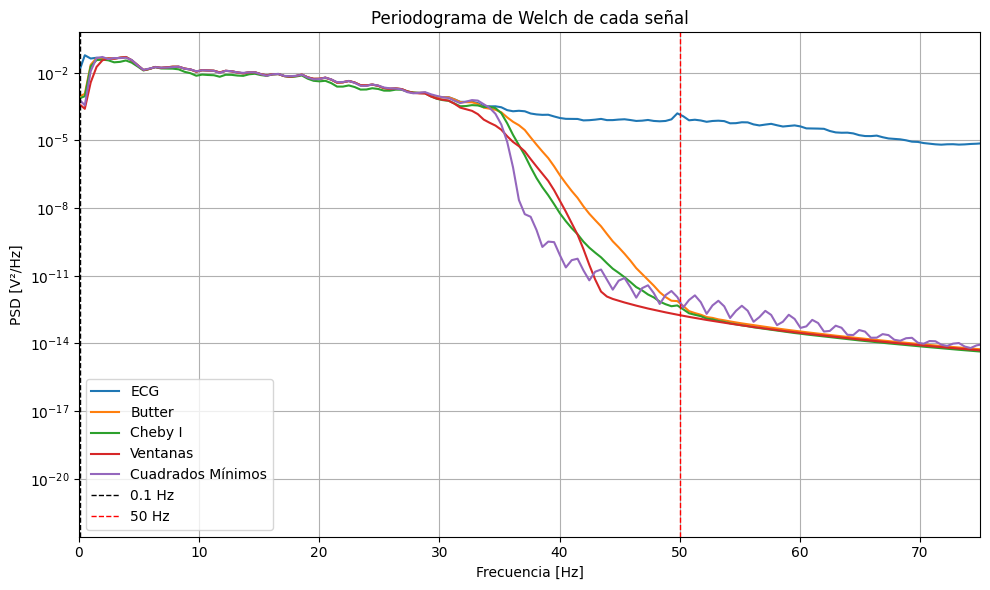

In [60]:

############# GRÁFICOS ESPECTRALES #############
f_ecg, Pxx_ecg = sig.welch(ecg, fs=fs, nperseg=nperseg)
f_butter, Pxx_butter = sig.welch(ecg_butter, fs=fs, nperseg=nperseg)
f_cheby, Pxx_cheby = sig.welch(ecg_cheby, fs=fs, nperseg=nperseg)
f_vent, Pxx_vent = sig.welch(ecg_vent, fs=fs, nperseg=nperseg)
f_cuad, Pxx_cuad = sig.welch(ecg_cuad, fs=fs, nperseg=nperseg)

plt.figure(figsize=(10, 6))
plt.semilogy(f_ecg, Pxx_ecg, label='ECG')
plt.semilogy(f_butter, Pxx_butter, label='Butter')
plt.semilogy(f_cheby, Pxx_cheby, label='Cheby I')
plt.semilogy(f_vent, Pxx_vent, label='Ventanas')
plt.semilogy(f_cuad, Pxx_cuad, label='Cuadrados Mínimos')

plt.axvline(0.1, color='k', linestyle='--', linewidth=1, label='0.1 Hz')
plt.axvline(50, color='r', linestyle='--', linewidth=1, label='50 Hz')

plt.title('Periodograma de Welch de cada señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.xlim(0, 75)
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Bonus! filtrado de señal de audio.

voy a jugar con el filtro a ver que pasa si le pongo estos valores

f_stop1 = 100   
f_pass1 = 300    
f_pass2 = 3400    
f_stop2 = 4000    

In [61]:

from scipy.io import wavfile
import os

# Cargar la señal de audio
fs, audio = sio.wavfile.read('la cucaracha.wav')

# Normalización tipo z-score
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

audio = normalize(audio)

# Crear vector de tiempo
t_audio = np.arange(len(audio)) / fs


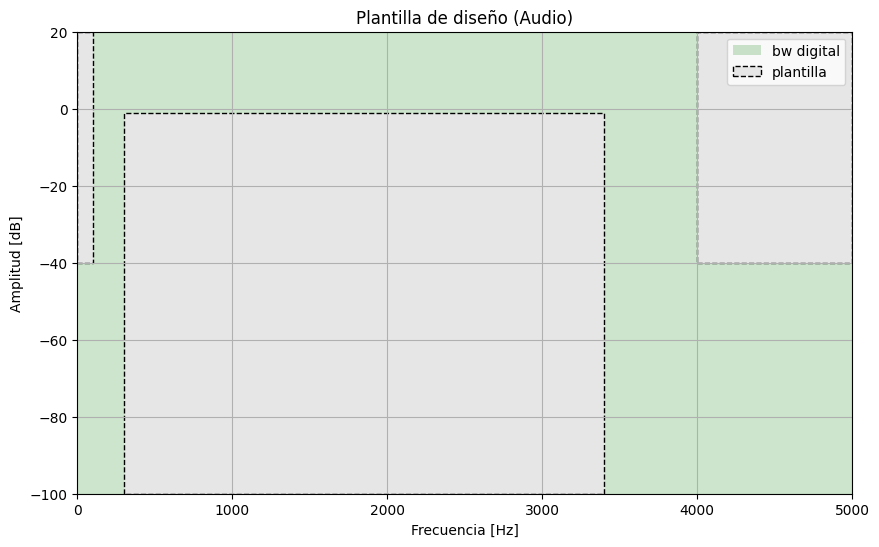

In [62]:

#########################################
########## PLANTILLA DE DISEÑO ##########
#########################################

# Banda pasante para voz: 300 Hz a 3400 Hz
fpass = np.array([300, 3400])
ripple = 1          # dB de ondulación en la banda pasante
fstop = np.array([100, 4000])
attenuation = 40    # dB de atenuación fuera de banda

# Mostrar plantilla
plt.figure(figsize=(10, 6))
plt.title('Plantilla de diseño (Audio)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 5000)
plt.ylim(-100, 20)
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple,
               fstop=fstop, attenuation=attenuation, fs=fs)

# Frecuencias para evaluar la respuesta en frecuencia
w_rad = np.linspace(0, fs / 2, 600, endpoint=True)


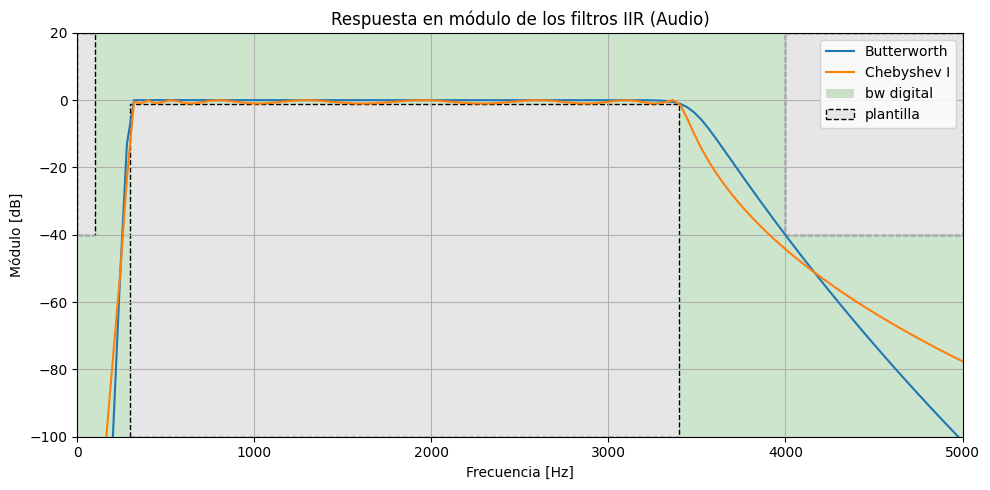

In [63]:

###########################################
############### FILTROS IIR ###############
###########################################

# Filtro Butterworth
sos_filter_butter = sig.iirdesign(fpass, fstop, ripple, attenuation,
                                  ftype='butter', output='sos', fs=fs)
w_b, hh_b = sig.sosfreqz(sos_filter_butter, worN=w_rad, fs=fs)

# Filtro Chebyshev tipo I
sos_filter_cheby = sig.iirdesign(fpass, fstop, ripple, attenuation,
                                 ftype='cheby1', output='sos', fs=fs)
w_c, hh_c = sig.sosfreqz(sos_filter_cheby, worN=w_rad, fs=fs)

# Graficar respuestas en frecuencia
plt.figure(figsize=(10, 5))
plt.plot(w_b, 20 * np.log10(np.abs(hh_b) + 1e-15), label='Butterworth')
plt.plot(w_c, 20 * np.log10(np.abs(hh_c) + 1e-15), label='Chebyshev I')
plt.title('Respuesta en módulo de los filtros IIR (Audio)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 5000)
plt.ylim(-100, 20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple,
               fstop=fstop, attenuation=attenuation, fs=fs)



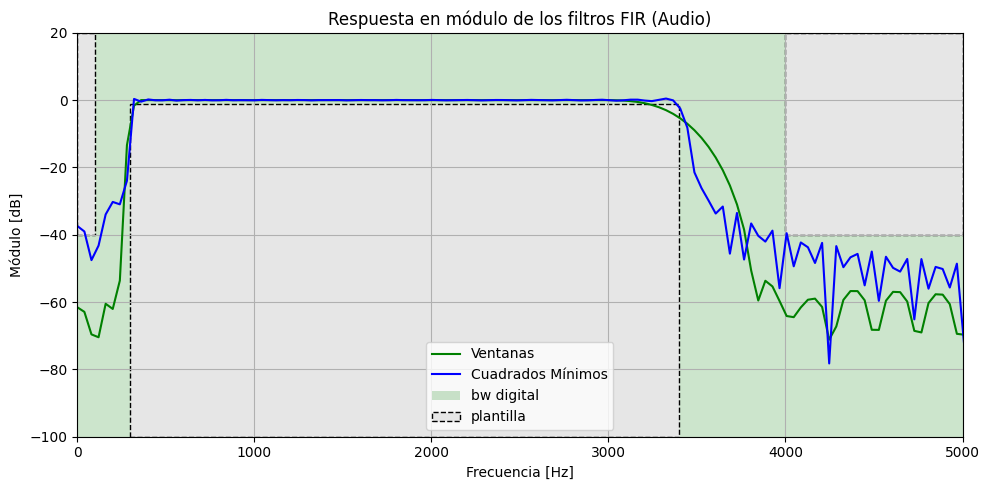

In [64]:

###########################################
############### FILTROS FIR ###############
###########################################

######### MÉTODO DE VENTANAS #########

# --- Pasaaltos FIR (ventanas) ---
freq_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
gain_hp = [0, 0, 1, 1]
freq_hp = np.array(freq_hp)

numtaps_hp = 1501
b_hp = sig.firwin2(numtaps_hp, freq_hp, gain_hp, fs=fs)

# --- Pasabajos FIR (ventanas) ---
freq_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
gain_lp = [1, 1, 0, 0]
freq_lp = np.array(freq_lp)

numtaps_lp = 201
b_lp = sig.firwin2(numtaps_lp, freq_lp, gain_lp, fs=fs)

# --- Filtro pasabanda por convolución ---
b_vent = np.convolve(b_hp, b_lp)

# --- Respuesta en frecuencia ---
w_fir, h_fir = sig.freqz(b_vent, worN=w_rad, fs=fs)

######### MÉTODO DE CUADRADOS MÍNIMOS #########

# --- Pasaaltos FIR (firls) ---
numtaps = 1501
bands_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
desired_hp = [0, 0, 1, 1]
bands_hp = np.array(bands_hp) / (fs / 2)
b_firls_hp = firls(numtaps, bands_hp, desired_hp)

# --- Pasabajos FIR (firls) ---
numtaps = 501
bands_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
desired_lp = [1, 1, 0, 0]
bands_lp = np.array(bands_lp) / (fs / 2)
b_firls_lp = firls(numtaps, bands_lp, desired_lp)

# --- Filtro pasabanda por convolución ---
b_firls = np.convolve(b_firls_hp, b_firls_lp)

# --- Respuesta en frecuencia ---
w_firls, h_firls = sig.freqz(b_firls, worN=w_rad, fs=fs)

######### GRAFICAR RESPUESTAS #########

plt.figure(figsize=(10, 5))
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-15), label='Ventanas', color='green')
plt.plot(w_firls, 20 * np.log10(np.abs(h_firls) + 1e-15), label='Cuadrados Mínimos', color='blue')
plt.title('Respuesta en módulo de los filtros FIR (Audio)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 5000)
plt.ylim(-100, 20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple,
               fstop=fstop, attenuation=attenuation, fs=fs)
plt.show()



In [65]:

#########################################
######### APLICANDO LOS FILTROS #########
#########################################

# Aplicar filtros IIR (sin desfase)
audio_butter = sig.sosfiltfilt(sos_filter_butter, audio)
audio_cheby = sig.sosfiltfilt(sos_filter_cheby, audio)

# Aplicar filtros FIR (sin desfase)
audio_vent = sig.filtfilt(b_vent, 1.0, audio)
audio_cuad = sig.filtfilt(b_firls, 1.0, audio)



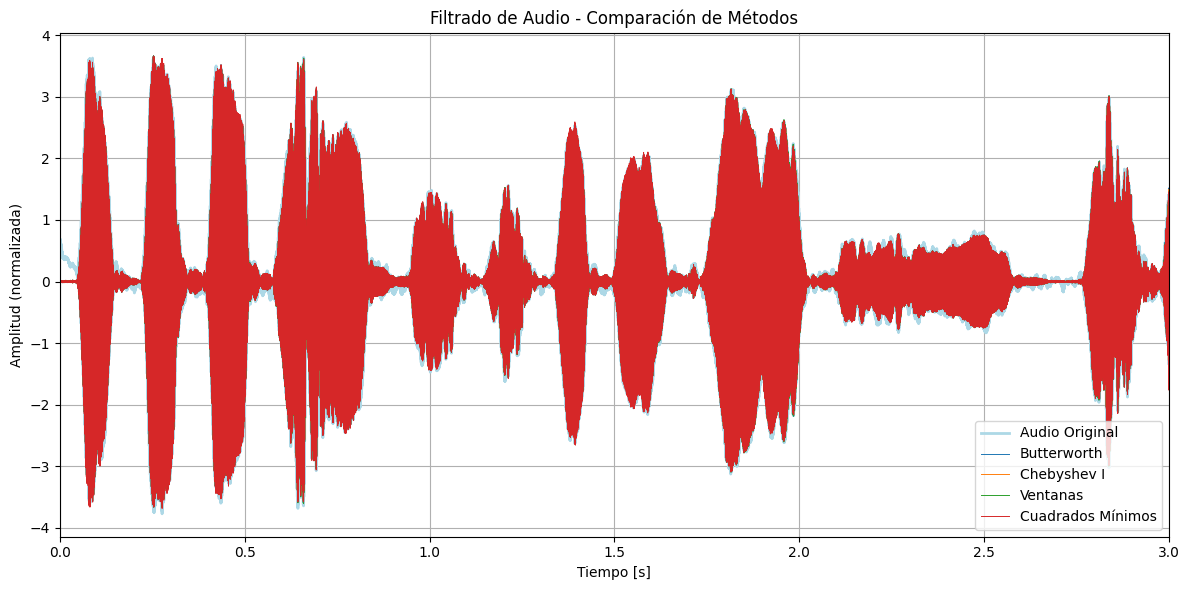

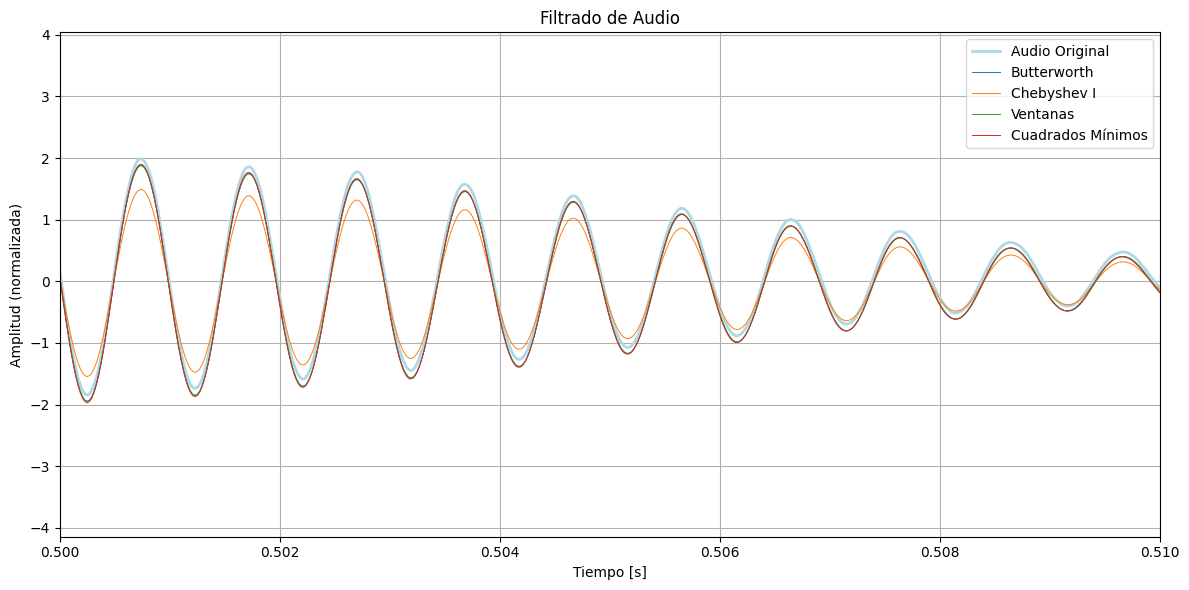

In [66]:

#########################################
############# GRAFICANDO ################
#########################################

plt.figure(figsize=(12, 6))

# Señal original
plt.plot(t_audio, audio, label='Audio Original', color='lightblue', linewidth=2)

# Señales filtradas
plt.plot(t_audio, audio_butter, label='Butterworth', linewidth=0.7)
plt.plot(t_audio, audio_cheby, label='Chebyshev I', linewidth=0.7)
plt.plot(t_audio, audio_vent, label='Ventanas', linewidth=0.7)
plt.plot(t_audio, audio_cuad, label='Cuadrados Mínimos', linewidth=0.7)

plt.title('Filtrado de Audio - Comparación de Métodos')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud (normalizada)')
plt.legend()
plt.grid(True)
plt.xlim(0, 3)  # Mostrar solo los primeros 5 segundos
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Señal original
plt.plot(t_audio, audio, label='Audio Original', color='lightblue', linewidth=2)

# Señales filtradas
plt.plot(t_audio, audio_butter, label='Butterworth', linewidth=0.7)
plt.plot(t_audio, audio_cheby, label='Chebyshev I', linewidth=0.7)
plt.plot(t_audio, audio_vent, label='Ventanas', linewidth=0.7)
plt.plot(t_audio, audio_cuad, label='Cuadrados Mínimos', linewidth=0.7)

plt.title('Filtrado de Audio')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud (normalizada)')
plt.legend()
plt.grid(True)
plt.xlim(0.5, 0.51)  # Mostrar solo los primeros 5 segundos
plt.tight_layout()
plt.show()


In [67]:
from scipy.io.wavfile import write

# Convertir a tipo int16 si es necesario (rango -32768 a 32767)
def to_int16(signal):
    signal = signal / np.max(np.abs(signal))  # normaliza a [-1, 1]
    return np.int16(signal * 32767)

# Guardar señales filtradas
write('audio_butter.wav', fs, to_int16(audio_butter))
write('audio_cheby.wav', fs, to_int16(audio_cheby))
write('audio_ventanas.wav', fs, to_int16(audio_vent))
write('audio_cuadrados.wav', fs, to_int16(audio_cuad))

#### Conclusiones del filtrado de audio

Con respecto a la performance de los diferentes tipos de filtros, la encuentro muy similar que para el ecg.

Al escuchar los audios, se nota que los filtrados se oyen más alto. Supongo que esto ocurre por quitar las ondas lentas. Entre los diferentes tipos de filtos no encuentor diferencia al oido 